In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import math
from tqdm import tqdm
from matplotlib import pyplot as plt

OUTPUT_DIR = "./output"
path_to_figure5 = "./Figure_5.pdf"
path_to_figure6 = "./Figure_6.pdf"
path_to_table4 = "./Table_4.md"

In [3]:
# load output

metrics = [
    "FDG:0.0","FDG:0.1","FDG:0.3","FDG:0.5","FDG:0.7","FDG:0.9","FDG:1.0",
    "Prox","S3"
]
dfs = {metric: {} for metric in metrics}
for metric in metrics:
    frames = []
    for budget in os.listdir(OUTPUT_DIR):
        if not os.path.isdir(os.path.join(OUTPUT_DIR, budget)):
            continue
        for ts in os.listdir(os.path.join(OUTPUT_DIR, budget)):
            df = pd.read_pickle(os.path.join(
                OUTPUT_DIR, budget, ts, metric+".pkl"))
            assert (df["Test Suite"] == ts).all()
            assert (df["Time Budget"] == int(budget)).all()
            frames.append(df)
    dfs[metric] = pd.concat(frames)

# Figure 5: acc@n values for query budgets

In [4]:
def draw_acc_graph(df, N=[1,3,5,10], query_budgets=[0,1,3,5,10],
    figsize=None, savepath=None):
    tdf = df[df["Query Budget"].isin(query_budgets)]
    tdf = tdf[tdf["Noise Probability"] == 0.0]
    # get higest rank amont all buggy elements
    mdf = tdf.groupby(["Test Suite", "Time Budget", "Query Budget",
        "Project", "Version"]).min()
    # add helper columns to calculate acc@n
    for n in N:
        mdf[f"acc@{n}"] = (mdf["Rank"] <= n).astype(float)
    mdf.reset_index(inplace=True)
    num_subjects = mdf[["Project", "Version"]].drop_duplicates().shape[0]
    print(f"# Subjects: {num_subjects}")

    # Calculate the averaged acc@n over all test suite
    acc_n_for_each_bug = mdf.groupby(["Test Suite", "Time Budget",
        "Query Budget", "Project", "Version"]).mean()[[f"acc@{n}" for n in N]]

    acc_n = acc_n_for_each_bug.groupby(
        ["Test Suite", "Time Budget", "Query Budget"]).sum()
    acc_n = acc_n.reset_index()

    # melt down the table
    unpivoted = acc_n.melt(
        id_vars=["Test Suite", "Time Budget", "Query Budget"], 
        var_name="metric", value_name="value")
    unpivoted["Time Budget (min)"] = unpivoted["Time Budget"]/60
    
    # convert the unit of time budget to minute
    time_budgets = unpivoted["Time Budget (min)"].unique()

    plt.figure(figsize=(7,6) if figsize is None else figsize)    
    for i, tb in enumerate(time_budgets):
        plt.subplot(2, math.ceil(len(time_budgets)/2), i+1)
        plt.title(f"Time Budget ($b_t$): {int(tb)} mins (T{int(tb)})")
        plt.grid(zorder=0)
        ax = sns.barplot(
            data=unpivoted[unpivoted["Time Budget (min)"] == tb],
            x="metric",
            y="value",
            hue="Query Budget",
            zorder=2
        )
        for p in ax.patches:
            ax.annotate(format(p.get_height(), ".0f"),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = "center", va = "center", xytext = (0, 10),
                        textcoords = "offset points", fontsize=9)
        if i != len(time_budgets) - 1:
            plt.xlabel("")
            xtick_pos = plt.xticks()[0]
            plt.xticks(xtick_pos, ["" for _ in xtick_pos])
        offset = 20
        ymax = unpivoted[unpivoted["Time Budget (min)"] == tb]["value"].max()
        plt.ylim(0, ymax+offset)
        plt.legend(loc="upper left", title="# Queries", prop={"size": 9})
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()
    return unpivoted

# Subjects: 349


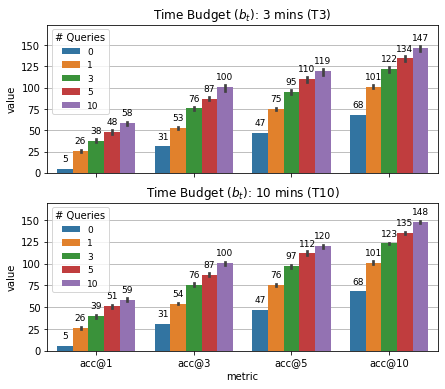

Saved to ./Figure_5.pdf


In [5]:
draw_acc_graph(dfs["FDG:0.5"], savepath=path_to_figure5)
print(f"Saved to {path_to_figure5}")

# Figure 6: Robustness

In [6]:
def draw_robustness_graph(df, noise_probs=[0.0,0.1,0.3,0.5,0.7,0.9], n=10,
    query_budgets=[0,1,2,3,4,5,6,7,8,9,10], savepath=None):
    mdf = df[df["Query Budget"].isin(query_budgets)]
    mdf = mdf[mdf["Noise Probability"].isin(noise_probs)]
    mdf = mdf.groupby(['Test Suite', 'Time Budget', 'Query Budget',
        'Noise Probability', 'Project', 'Version']).min()

    # Helper columns to calculate acc@n
    mdf[f'acc@{n}'] = mdf['Rank'] <= n

    # Calculate the averaged acc@n over all test suite
    acc_n_for_each_bug = mdf.groupby([
        'Test Suite', 'Time Budget', 'Query Budget',
        'Noise Probability', 'Project', 'Version'
        ]).mean()[f'acc@{n}']

    acc_n = acc_n_for_each_bug.groupby(
        ['Test Suite', 'Time Budget', 'Query Budget', 'Noise Probability']
    ).sum()
    acc_n = acc_n.reset_index()

    # melt down the table
    unpivoted = acc_n.melt(id_vars=['Test Suite', 'Time Budget', 'Noise Probability', 'Query Budget'], var_name='metric', value_name='value')
    unpivoted['Time Budget (min)'] = unpivoted['Time Budget']/60
    unpivoted['Noise Prob. (p)'] = unpivoted['Noise Probability']

    plt.figure(figsize=(8,4))
    for i, tb in enumerate(sorted(unpivoted['Time Budget (min)'].unique())):
        plt.subplot(1,2,i+1)
        plt.title(f"Time Budget ($b_t$): {int(tb)} mins (T{int(tb)})")
        ax = sns.lineplot(
            data=unpivoted[
                (unpivoted['metric'] == f"acc@{n}") \
                & (unpivoted['Time Budget (min)'] == tb)],
            x='Query Budget',
            y='value',
            hue='Noise Prob. (p)',
            legend='full',
            err_style='band',
        )
        if i == 0:
            plt.ylabel(f"acc@{n}")
        else:
            plt.ylabel(None)
        initial_value = unpivoted[
            (unpivoted['Query Budget'] == 0) \
            & (unpivoted['Time Budget (min)'] == tb)
        ].groupby(['Noise Probability']).mean()['value'].iloc[0]
        ax.text(0.2, initial_value-1.3, "{:.0f}".format(initial_value), 
            size='medium', color='black', horizontalalignment='left')
        ten_values = unpivoted[
            (unpivoted['Query Budget'] == 10) \
            & (unpivoted['Time Budget (min)'] == tb)
        ].groupby(['Noise Probability']).mean()['value']
        for dp in range(ten_values.shape[0]):
            ax.text(10 + 0.05, ten_values.iloc[dp],
                "{:.0f}".format(ten_values.iloc[dp].round(1)),
                verticalalignment='center', size='medium', color='black')
        plt.grid(color='lightgrey', zorder=0)
        plt.xlim(-.5, 11)

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

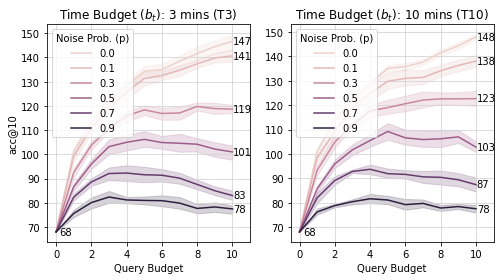

In [7]:
draw_robustness_graph(
    dfs["FDG:0.5"], n=10,
    noise_probs=[0.0,0.1,0.3,0.5,0.7,0.9],
    query_budgets=[0,1,2,3,4,5,6,7,8,9,10],
    savepath=path_to_figure6)

# Table 4: Parameter Tuning

In [8]:
def get_acc_n_dataframe(dfs, n, time_budget, noise_probabilty=0.0):
    df = pd.DataFrame()
    for metric in dfs:
        for query_budget in [1, 3, 5, 10]:
            tdf = dfs[metric]
            tdf = tdf[
                (tdf['Time Budget'] == time_budget)\
                & (tdf['Noise Probability'] == noise_probabilty)\
                & (tdf['Query Budget'] == query_budget)
            ].copy()
            tdf = tdf.drop(
                ['Noise Probability', 'Query Budget', 'Time Budget'], axis=1)
            tdf = tdf.groupby(
                ['Test Suite', 'Project', 'Version']).min().reset_index()

            tdf[f'acc@{n}'] = tdf['Rank'] <= n
            tdf = tdf.drop(['Rank'], axis=1)

            tdf = tdf.groupby(['Test Suite']).sum()
            tdf['metric'] = metric
            tdf['query_budget'] = query_budget
            df = df.append(tdf)
    return df.reset_index()

n = 10
df = get_acc_n_dataframe(dfs, n=n, time_budget = 600)
adf = df.groupby(['metric', 'query_budget']).mean()[f'acc@{n}'].reset_index()
table = adf.pivot('metric', 'query_budget', f'acc@{n}').round(1).to_markdown()

markdown = ""
markdown += f"# Table 4\n"
markdown += table
with open(path_to_table4, "w") as f:
    f.write(markdown)

print(f"Saved to {path_to_table4}")
print(markdown)

Saved to ./Table_4.md
# Table 4
| metric   |     1 |     3 |     5 |    10 |
|:---------|------:|------:|------:|------:|
| FDG:0.0  |  98.7 | 121.9 | 131.3 | 143.5 |
| FDG:0.1  |  98.7 | 122.1 | 131.8 | 144.9 |
| FDG:0.3  |  98.7 | 125.3 | 135.9 | 146.6 |
| FDG:0.5  | 101.1 | 123.1 | 135.1 | 148   |
| FDG:0.7  |  98.1 | 126.1 | 135.9 | 148.7 |
| FDG:0.9  |  93.3 | 125.7 | 135.3 | 151.7 |
| FDG:1.0  |  91.2 | 120.6 | 139.5 | 151.4 |
| Prox     |  99.5 | 119.7 | 126.6 | 137.8 |
| S3       |  91.8 | 117.3 | 133.9 | 146.3 |
